In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model
import torch

import loader
from models import MLPClassifier, BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
split_ratio_calib = 0.3
n_bins_calib = 70

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome5.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=5,
        sensitive_attr='RAC1P',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^RAC1P_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,White alone,Black or African American alone,American Indian or Alaska Native alone,"Asian, Native Hawaiian or Other Pacific Islander alone",Other
Target,,,,,
"[0, 15000.0)",233290,36347,3883,18727,26646
"[15000.0, 30000.0)",232268,35779,3803,16333,27630
"[30000.0, 48600.0)",284095,34890,3652,17202,24060
"[48600.0, 78030.0)",273015,24328,2296,17719,15618
"[78030.0, inf)",275458,16229,1263,29231,10738


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.7997254608673681


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

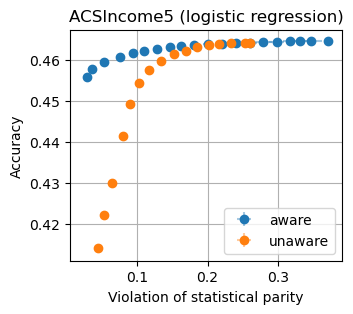

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464564  0.000259  0.370922  0.002360     0.190931  0.001239
0.360  0.464595  0.000249  0.347344  0.015449     0.180763  0.006747
0.340  0.464580  0.000266  0.331930  0.011299     0.174508  0.004671
0.320  0.464550  0.000260  0.317070  0.010030     0.168425  0.004010
0.300  0.464466  0.000243  0.298330  0.011073     0.160901  0.003892
0.280  0.464353  0.000255  0.279483  0.011664     0.154233  0.003821
0.260  0.464260  0.000242  0.259786  0.010209     0.148006  0.003139
0.240  0.464167  0.000271  0.241049  0.009270     0.142553  0.002976
0.220  0.464031  0.000257  0.220209  0.008328     0.137592  0.002544
0.200  0.463887  0.000258  0.200110  0.006831     0.133602  0.002066
0.180  0.463724  0.000279  0.181148  0.006154     0.129590  0.002498
0.160  0.463433  0.000270  0.162383  0.003055     0.125814  0.003755
0.140  0.463096  0.000370  0.146087  0.002930     0.114195  0.004495
0.120  0.462649  0.000358  0.127451  0.005455     0.097424  0.004219
0.100  0.462259  0.000378  0.108860  0.003272     0.087809  0.001985
0.080  0.461624  0.000447  0.093546  0.003420     0.075483  0.003505
0.060  0.460708  0.000522  0.075407  0.003346     0.058219  0.003697
0.040  0.459473  0.000640  0.051950  0.003776     0.040399  0.004608
0.020  0.457790  0.000712  0.035344  0.005448     0.023719  0.003961
0.001  0.455798  0.000774  0.028151  0.006167     0.016388  0.003235

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464183  0.000329  0.259807  0.003282     0.132599  0.000946
0.260  0.464253  0.000335  0.253270  0.005049     0.131113  0.001414
0.240  0.464192  0.000354  0.233523  0.004233     0.126150  0.001227
0.220  0.463948  0.000352  0.216231  0.002386     0.121296  0.001159
0.200  0.463711  0.000367  0.202047  0.002755     0.117226  0.001179
0.180  0.463156  0.000435  0.185469  0.003003     0.113151  0.001238
0.160  0.462277  0.000442  0.168914  0.003216     0.109720  0.001252
0.140  0.461465  0.000485  0.151488  0.003091     0.105734  0.000999
0.120  0.459825  0.000478  0.133049  0.002569     0.099364  0.000716
0.100  0.457613  0.000344  0.116762  0.002537     0.088363  0.000757
0.080  0.454448  0.000237  0.101974  0.003096     0.077337  0.001019
0.060  0.449276  0.000378  0.089561  0.003868     0.063362  0.000937
0.040  0.441537  0.000632  0.078933  0.003609     0.052729  0.001642
0.020  0.429815  0.000778  0.063834  0.004735     0.037189  0.002132
0.010  0.421983  0.000623  0.052610  0.004544     0.029416  0.002381
0.001  0.414105  0.000630  0.043227  0.004801     0.025697  0.002515

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16,
        0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

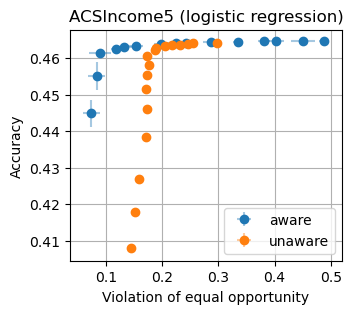

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464564  0.000259   0.488157  0.009126       0.233915  0.004167
0.450  0.464588  0.000251   0.450973  0.021557       0.217400  0.009583
0.400  0.464589  0.000257   0.401793  0.015439       0.198790  0.005071
0.350  0.464564  0.000255   0.381539  0.011046       0.192639  0.005470
0.300  0.464478  0.000267   0.334663  0.009405       0.170356  0.003829
0.250  0.464267  0.000269   0.286500  0.012983       0.151392  0.004589
0.200  0.464098  0.000284   0.242779  0.017851       0.135961  0.006071
0.180  0.463978  0.000283   0.224463  0.015377       0.131262  0.005412
0.150  0.463815  0.000291   0.198752  0.013342       0.122907  0.005233
0.100  0.463318  0.000313   0.152961  0.012929       0.098010  0.004396
0.080  0.462989  0.000309   0.131966  0.013632       0.086910  0.004799
0.050  0.462561  0.000353   0.118502  0.008948       0.077085  0.004356
0.020  0.461419  0.000659   0.089380  0.018801       0.056652  0.004992
0.010  0.455026  0.003730   0.083529  0.015212       0.049174  0.006564
0.001  0.444919  0.003696   0.073897  0.015342       0.040630  0.006665

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464183  0.000329   0.297076  0.003070       0.142190  0.000590
0.300  0.463992  0.000379   0.254195  0.006396       0.119160  0.002719
0.280  0.463815  0.000373   0.245559  0.006723       0.114188  0.003014
0.260  0.463656  0.000395   0.232323  0.007686       0.108420  0.001830
0.240  0.463501  0.000386   0.217130  0.006701       0.107280  0.001732
0.220  0.463246  0.000419   0.204487  0.006869       0.108162  0.002219
0.200  0.462732  0.000386   0.188686  0.005017       0.107413  0.002336
0.180  0.462218  0.000407   0.186558  0.006007       0.106430  0.002577
0.150  0.460468  0.000404   0.172778  0.005943       0.101939  0.002392
0.120  0.457971  0.000314   0.176598  0.005994       0.090365  0.002707
0.100  0.455283  0.000327   0.172895  0.006927       0.085485  0.001602
0.080  0.451563  0.000412   0.170982  0.006158       0.082831  0.002040
0.060  0.446142  0.000489   0.173478  0.004461       0.081206  0.002226
0.040  0.438428  0.000500   0.171404  0.003643       0.080071  0.002911
0.020  0.426881  0.000384   0.159634  0.006372       0.079795  0.003220
0.010  0.417965  0.000222   0.152092  0.006144       0.073797  0.002743
0.001  0.407964  0.000526   0.145312  0.005861       0.067691  0.002578

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

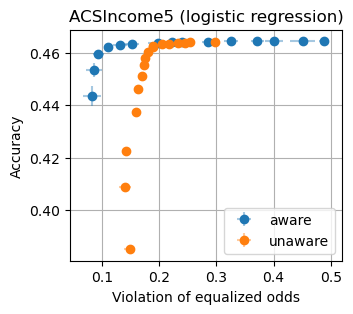

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464564  0.000259  0.488157  0.009126     0.169337  0.001559
0.450  0.464588  0.000251  0.450973  0.021557     0.161099  0.006037
0.400  0.464594  0.000256  0.400814  0.016162     0.148662  0.006463
0.350  0.464572  0.000264  0.372035  0.011107     0.138506  0.004220
0.300  0.464439  0.000255  0.325761  0.012329     0.125238  0.003403
0.250  0.464296  0.000243  0.286376  0.011970     0.114282  0.003465
0.200  0.464123  0.000264  0.240433  0.011727     0.101814  0.002856
0.180  0.463986  0.000288  0.222237  0.015136     0.093979  0.004681
0.150  0.463773  0.000316  0.197796  0.016576     0.085184  0.003419
0.100  0.463287  0.000323  0.152081  0.012168     0.066584  0.003111
0.080  0.462883  0.000323  0.131640  0.011908     0.058852  0.003790
0.050  0.462403  0.000360  0.111080  0.007179     0.045101  0.003089
0.020  0.459585  0.001305  0.093621  0.009582     0.033969  0.003115
0.010  0.453637  0.002666  0.086800  0.014105     0.031011  0.003064
0.001  0.443530  0.003781  0.082721  0.016173     0.028271  0.003722

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464183  0.000329  0.297076  0.003070     0.095359  0.001645
0.300  0.463992  0.000379  0.254195  0.006396     0.082550  0.001511
0.280  0.463815  0.000373  0.245559  0.006723     0.080142  0.001487
0.260  0.463656  0.000395  0.232323  0.007686     0.079279  0.000914
0.240  0.463501  0.000386  0.217130  0.006701     0.080208  0.000856
0.220  0.463246  0.000419  0.204487  0.006869     0.080712  0.000940
0.200  0.462732  0.000386  0.189870  0.002758     0.080244  0.000976
0.180  0.462218  0.000407  0.188737  0.002854     0.079703  0.001010
0.150  0.460537  0.000401  0.180962  0.003934     0.075316  0.001303
0.120  0.458189  0.000306  0.176060  0.005056     0.069662  0.001356
0.100  0.455285  0.000324  0.174400  0.007551     0.065877  0.001553
0.080  0.451330  0.000369  0.170056  0.006058     0.063244  0.001315
0.060  0.446055  0.000498  0.162548  0.006569     0.059095  0.002124
0.040  0.437431  0.000488  0.160053  0.005235     0.055734  0.001714
0.020  0.422542  0.000714  0.142947  0.005605     0.049980  0.001404
0.010  0.408838  0.000548  0.140510  0.010750     0.047035  0.001565
0.001  0.385051  0.000439  0.148763  0.009887     0.047809  0.001865

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 1048635, number of used features: 49
[LightGBM] [Info] Start training from score -1.653538
[LightGBM] [Info] Start training from score -1.660092
[LightGBM] [Info] Start training from score -1.520087
[LightGBM] [Info] Start training from score -1.607766
[LightGBM] [Info] Start training from score -1.612045


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 1048635, number of used features: 44
[LightGBM] [Info] Start training from score -1.965724
[LightGBM] [Info] Start training from score -1.969175
[LightGBM] [Info] Start training from score -1.768546
[LightGBM] [Info] Start training from score -1.806025
[LightGBM] [Info] Start training from score -1.801941
[LightGBM] [Info] Start training from score -3.821840
[LightGBM] [Info] Start training from score -3.833497
[LightGBM] [Info] Start training from score -3.863339
[LightGBM] [Info] Start training from score -4.225237
[LightGBM] [Info] Start training from score -4.635213
[LightGBM] [Info] Start training from score -6.066120
[LightGBM] [Info] Start training from score -6.06694

Calibration error of attribute-blind predictor: 1.5950976975529958


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

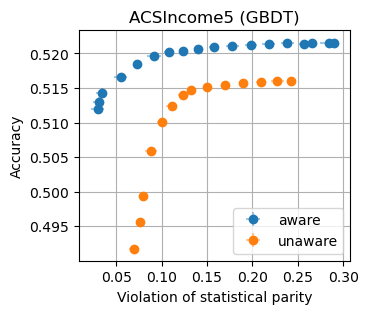

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.521496  0.000423  0.289463  0.001685     0.149497  0.001047
0.300  0.521491  0.000412  0.284226  0.010023     0.147538  0.004010
0.280  0.521466  0.000419  0.265982  0.003463     0.140807  0.000949
0.260  0.521443  0.000433  0.256917  0.005213     0.137679  0.002251
0.240  0.521450  0.000437  0.238389  0.007022     0.130742  0.002137
0.220  0.521397  0.000406  0.217848  0.006996     0.124566  0.002020
0.200  0.521269  0.000418  0.198174  0.006897     0.119288  0.001714
0.180  0.521098  0.000419  0.177993  0.006696     0.114950  0.001375
0.160  0.520880  0.000391  0.158128  0.005463     0.111640  0.000989
0.140  0.520668  0.000396  0.140050  0.004867     0.109752  0.001232
0.120  0.520382  0.000410  0.123794  0.002177     0.097770  0.004552
0.100  0.520163  0.000438  0.108141  0.005543     0.084486  0.002066
0.080  0.519641  0.000433  0.091331  0.007665     0.073108  0.001073
0.060  0.518547  0.000518  0.073364  0.005095     0.058096  0.003909
0.040  0.516542  0.000630  0.055035  0.007020     0.041582  0.004549
0.020  0.514308  0.000682  0.033937  0.006391     0.024618  0.004321
0.010  0.512968  0.000697  0.030602  0.005695     0.020196  0.003867
0.001  0.511999  0.000657  0.029554  0.006787     0.018295  0.004364

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.516011  0.000385  0.242268  0.002085     0.128866  0.000698
0.220  0.515949  0.000372  0.227269  0.007070     0.123874  0.002358
0.200  0.515859  0.000369  0.209625  0.005759     0.118276  0.002003
0.180  0.515682  0.000369  0.189982  0.004245     0.112723  0.001473
0.160  0.515438  0.000392  0.169860  0.003132     0.108111  0.001161
0.140  0.515110  0.000389  0.150415  0.003003     0.104872  0.001037
0.120  0.514653  0.000399  0.132659  0.003418     0.101944  0.001722
0.100  0.513918  0.000459  0.123578  0.006022     0.088395  0.001469
0.080  0.512334  0.000454  0.111353  0.006078     0.073397  0.000759
0.060  0.510044  0.000387  0.100434  0.005715     0.060504  0.002289
0.040  0.505816  0.000357  0.088159  0.006606     0.051339  0.004094
0.020  0.499308  0.000247  0.079540  0.004991     0.045634  0.003660
0.010  0.495613  0.000244  0.075677  0.004139     0.043164  0.003461
0.001  0.491759  0.000238  0.069067  0.004459     0.039690  0.003662

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

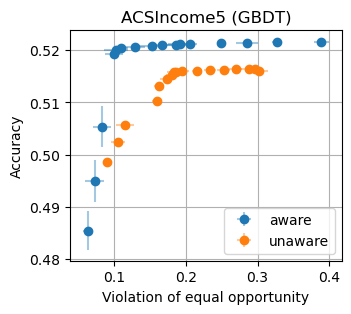

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.521496  0.000423   0.389024  0.010882       0.193589  0.004177
0.350  0.521489  0.000432   0.327109  0.007184       0.163661  0.003505
0.300  0.521446  0.000409   0.284670  0.015347       0.143601  0.006968
0.250  0.521389  0.000405   0.249233  0.005471       0.127749  0.001854
0.200  0.521266  0.000410   0.205165  0.010256       0.113416  0.002147
0.180  0.521191  0.000398   0.191791  0.016966       0.109521  0.002189
0.160  0.521096  0.000381   0.185969  0.019573       0.106766  0.001931
0.140  0.521003  0.000408   0.167211  0.020237       0.098937  0.003312
0.120  0.520837  0.000419   0.151986  0.021431       0.092234  0.001836
0.100  0.520663  0.000394   0.128449  0.014351       0.080148  0.002478
0.080  0.520374  0.000433   0.109957  0.008724       0.068679  0.001830
0.060  0.520013  0.000386   0.102474  0.016263       0.062220  0.007066
0.040  0.519235  0.000533   0.099516  0.012006       0.062069  0.004286
0.020  0.505391  0.003877   0.083237  0.012609       0.049099  0.006186
0.010  0.494982  0.003952   0.072835  0.013426       0.042497  0.006166
0.001  0.485449  0.003748   0.063300  0.007532       0.038710  0.004588

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.516011  0.000385   0.302569  0.011415       0.148988  0.003712
0.280  0.516363  0.000399   0.296082  0.010698       0.143140  0.003495
0.260  0.516393  0.000377   0.288366  0.011472       0.139169  0.003948
0.240  0.516324  0.000406   0.269187  0.008992       0.128497  0.003204
0.220  0.516290  0.000388   0.252570  0.008948       0.119523  0.003297
0.200  0.516177  0.000369   0.234014  0.008600       0.110412  0.002920
0.180  0.516071  0.000355   0.215277  0.007192       0.101860  0.002474
0.160  0.515952  0.000380   0.194854  0.009954       0.098035  0.001330
0.140  0.515836  0.000396   0.183782  0.009908       0.097610  0.001115
0.120  0.515740  0.000443   0.185809  0.009891       0.094434  0.001768
0.100  0.515253  0.000414   0.179849  0.007152       0.090344  0.002731
0.080  0.514559  0.000371   0.173196  0.009560       0.087443  0.003827
0.060  0.513115  0.000278   0.161889  0.006817       0.083927  0.002952
0.040  0.510263  0.000224   0.159198  0.006414       0.080772  0.002296
0.020  0.505651  0.000177   0.114985  0.011936       0.068646  0.003805
0.010  0.502455  0.000285   0.104951  0.010052       0.064299  0.002041
0.001  0.498530  0.000327   0.089709  0.006097       0.059347  0.001987

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

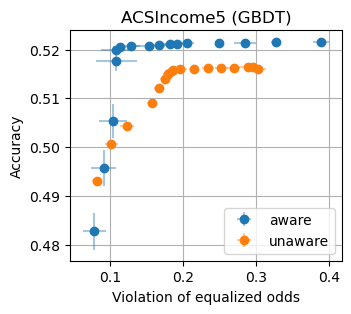

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.521496  0.000423  0.389024  0.010882     0.123070  0.001223
0.350  0.521489  0.000432  0.327109  0.007184     0.106015  0.001644
0.300  0.521446  0.000409  0.284670  0.015347     0.098079  0.000973
0.250  0.521389  0.000405  0.249233  0.005471     0.089383  0.000963
0.200  0.521253  0.000388  0.205234  0.010251     0.078908  0.000875
0.180  0.521180  0.000400  0.191569  0.016280     0.077931  0.000658
0.160  0.521061  0.000393  0.182546  0.013431     0.076474  0.001806
0.140  0.521030  0.000406  0.167689  0.019958     0.069786  0.002118
0.120  0.520824  0.000434  0.152878  0.023031     0.062484  0.001342
0.100  0.520685  0.000381  0.128229  0.012944     0.054152  0.001416
0.080  0.520432  0.000443  0.113237  0.008883     0.046217  0.001670
0.060  0.519964  0.000419  0.107757  0.019709     0.044417  0.004117
0.040  0.517584  0.001961  0.108991  0.027659     0.042909  0.005651
0.020  0.505317  0.003459  0.104141  0.019009     0.037136  0.005944
0.010  0.495713  0.003695  0.091374  0.017238     0.033297  0.004752
0.001  0.482707  0.003866  0.078485  0.015769     0.030625  0.004321

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.516011  0.000385  0.302569  0.011415     0.091463  0.001095
0.280  0.516363  0.000399  0.296082  0.010698     0.086898  0.000720
0.260  0.516393  0.000377  0.288366  0.011472     0.084711  0.000927
0.240  0.516324  0.000406  0.269187  0.008992     0.078316  0.000621
0.220  0.516290  0.000388  0.252570  0.008948     0.073444  0.000652
0.200  0.516176  0.000367  0.234014  0.008600     0.070770  0.000592
0.180  0.516083  0.000354  0.215254  0.007190     0.070685  0.000626
0.160  0.515949  0.000398  0.196240  0.009785     0.070503  0.000556
0.140  0.515771  0.000439  0.185769  0.009017     0.070133  0.000647
0.120  0.515600  0.000434  0.184357  0.008823     0.066405  0.000465
0.100  0.515018  0.000484  0.179490  0.006862     0.059208  0.001485
0.080  0.514054  0.000407  0.175991  0.007204     0.048943  0.001269
0.060  0.512183  0.000323  0.167370  0.007125     0.046000  0.001214
0.040  0.508963  0.000262  0.157103  0.006058     0.043231  0.000988
0.020  0.504258  0.000039  0.123124  0.009638     0.038251  0.001155
0.010  0.500600  0.000155  0.102114  0.008947     0.034026  0.000988
0.001  0.492986  0.000151  0.081949  0.006213     0.030315  0.001019

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## ReLU network

In [14]:
# Train attribute-aware p(Y | X) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.75459885381766


In [15]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

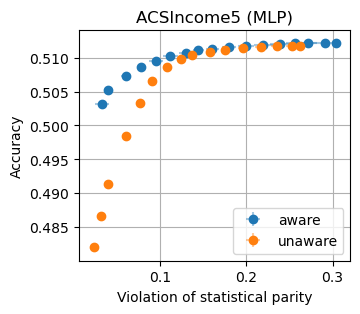

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.512184  0.000374  0.303978  0.002468     0.159516  0.001649
0.300  0.512173  0.000387  0.291341  0.013812     0.154385  0.006077
0.280  0.512157  0.000388  0.271932  0.010598     0.145928  0.005828
0.260  0.512117  0.000374  0.256347  0.010001     0.139497  0.004832
0.240  0.512029  0.000387  0.239325  0.012079     0.133386  0.005328
0.220  0.511872  0.000413  0.219458  0.011069     0.126957  0.004754
0.200  0.511705  0.000389  0.199832  0.009516     0.122206  0.004037
0.180  0.511571  0.000408  0.179914  0.008207     0.118259  0.003599
0.160  0.511317  0.000437  0.160524  0.007355     0.115487  0.002938
0.140  0.511076  0.000422  0.143875  0.006346     0.113272  0.003806
0.120  0.510736  0.000424  0.129811  0.008537     0.099787  0.005820
0.100  0.510261  0.000458  0.111529  0.008943     0.086159  0.003434
0.080  0.509547  0.000430  0.094949  0.008347     0.074254  0.004330
0.060  0.508626  0.000504  0.077371  0.004241     0.059026  0.004759
0.040  0.507281  0.000496  0.059744  0.005184     0.042607  0.006215
0.020  0.505258  0.000539  0.039752  0.005194     0.025153  0.004510
0.001  0.503112  0.000541  0.032494  0.008264     0.019001  0.006083

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511705  0.000305  0.261938  0.001125     0.137380  0.000694
0.260  0.511745  0.000291  0.252967  0.006860     0.133747  0.002958
0.240  0.511706  0.000308  0.235317  0.007220     0.127067  0.002949
0.220  0.511602  0.000349  0.216801  0.007257     0.120778  0.002764
0.200  0.511341  0.000396  0.195729  0.005078     0.114735  0.001811
0.180  0.511088  0.000368  0.175228  0.003850     0.110065  0.001434
0.160  0.510858  0.000381  0.157232  0.003361     0.106951  0.001186
0.140  0.510398  0.000389  0.136920  0.002063     0.104771  0.001043
0.120  0.509749  0.000404  0.124257  0.001631     0.097695  0.003142
0.100  0.508562  0.000431  0.107249  0.001624     0.083462  0.001203
0.080  0.506534  0.000365  0.090149  0.002738     0.070795  0.000568
0.060  0.503376  0.000548  0.075865  0.002917     0.055239  0.001163
0.040  0.498472  0.000592  0.060372  0.002135     0.041073  0.001952
0.020  0.491332  0.000433  0.038727  0.003336     0.024920  0.002095
0.010  0.486684  0.000412  0.031388  0.003969     0.018750  0.002233
0.001  0.482022  0.000407  0.022696  0.002670     0.012698  0.001485

In [16]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

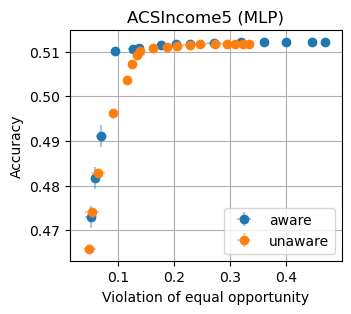

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.512184  0.000374   0.469709  0.006806       0.219057  0.002956
0.450  0.512179  0.000392   0.446686  0.008337       0.208798  0.004040
0.400  0.512151  0.000379   0.400084  0.007509       0.188557  0.003280
0.350  0.512159  0.000380   0.360017  0.006374       0.173925  0.004150
0.300  0.512070  0.000382   0.319256  0.013831       0.157380  0.005460
0.250  0.511992  0.000393   0.270939  0.012788       0.142701  0.002377
0.200  0.511711  0.000404   0.228560  0.007848       0.125049  0.005358
0.180  0.511636  0.000398   0.203889  0.008211       0.118959  0.003307
0.150  0.511502  0.000369   0.176611  0.007956       0.111722  0.003319
0.100  0.510933  0.000393   0.136371  0.008867       0.091991  0.004035
0.080  0.510667  0.000372   0.126923  0.010003       0.084165  0.004667
0.050  0.510095  0.000418   0.094766  0.007701       0.067186  0.006223
0.020  0.491175  0.002477   0.069640  0.009094       0.045463  0.007533
0.010  0.481639  0.002448   0.058631  0.007472       0.037207  0.007060
0.001  0.473042  0.002444   0.051282  0.009928       0.031742  0.008910

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.511705  0.000305   0.333984  0.006783       0.164945  0.002856
0.320  0.511735  0.000306   0.322615  0.007885       0.158142  0.004522
0.300  0.511791  0.000304   0.309275  0.007008       0.150617  0.003977
0.280  0.511792  0.000305   0.294122  0.008514       0.142074  0.004778
0.260  0.511754  0.000332   0.273606  0.011054       0.132299  0.005528
0.240  0.511648  0.000374   0.245980  0.012338       0.119877  0.005965
0.220  0.511453  0.000379   0.227851  0.011521       0.112776  0.004774
0.200  0.511265  0.000375   0.205538  0.011620       0.105805  0.003184
0.180  0.511078  0.000364   0.187506  0.010263       0.102270  0.003054
0.150  0.510771  0.000369   0.161216  0.004403       0.098384  0.002711
0.120  0.510096  0.000376   0.139091  0.006737       0.090586  0.002375
0.100  0.509189  0.000287   0.133909  0.004949       0.081300  0.001500
0.080  0.507239  0.000383   0.125054  0.004364       0.078029  0.002366
0.060  0.503658  0.000416   0.116053  0.006306       0.070755  0.003186
0.040  0.496364  0.000478   0.091186  0.006178       0.057832  0.002782
0.020  0.482883  0.000379   0.064044  0.012616       0.045093  0.003455
0.010  0.474094  0.000225   0.053341  0.011949       0.035453  0.002967
0.001  0.465784  0.000270   0.047981  0.011530       0.029062  0.004119

In [17]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

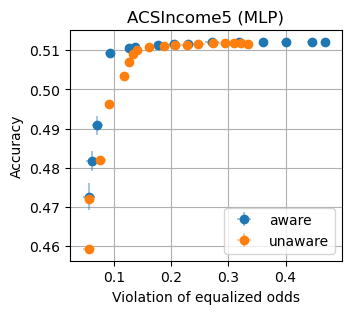

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.512184  0.000374  0.469709  0.006806     0.141252  0.001633
0.450  0.512179  0.000392  0.446686  0.008337     0.135277  0.003982
0.400  0.512151  0.000379  0.400084  0.007509     0.123294  0.003366
0.350  0.512159  0.000380  0.360017  0.006374     0.114075  0.001850
0.300  0.512070  0.000382  0.319256  0.013831     0.103814  0.002982
0.250  0.511992  0.000393  0.270939  0.012788     0.094248  0.002169
0.200  0.511706  0.000407  0.228537  0.007877     0.084304  0.002706
0.180  0.511640  0.000403  0.203979  0.008295     0.079828  0.003108
0.150  0.511413  0.000364  0.176058  0.006488     0.071948  0.002839
0.100  0.510895  0.000381  0.136367  0.008846     0.057675  0.002581
0.080  0.510683  0.000362  0.124999  0.005938     0.048155  0.003127
0.050  0.509221  0.001131  0.092249  0.008865     0.037760  0.005237
0.020  0.490895  0.002450  0.070317  0.010067     0.027384  0.006209
0.010  0.481674  0.002534  0.060519  0.009629     0.024361  0.006488
0.001  0.472609  0.003484  0.055541  0.011274     0.022147  0.007248

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511705  0.000305  0.333984  0.006783     0.100297  0.002155
0.320  0.511735  0.000306  0.322615  0.007885     0.095588  0.002681
0.300  0.511791  0.000304  0.309275  0.007008     0.090830  0.002129
0.280  0.511792  0.000305  0.294122  0.008514     0.086428  0.001796
0.260  0.511754  0.000332  0.273606  0.011054     0.082272  0.001777
0.240  0.511648  0.000374  0.245980  0.012338     0.078141  0.001862
0.220  0.511453  0.000379  0.227851  0.011521     0.074515  0.001840
0.200  0.511265  0.000375  0.205538  0.011620     0.071551  0.001291
0.180  0.511078  0.000364  0.187506  0.010263     0.070611  0.000819
0.150  0.510771  0.000369  0.161216  0.004403     0.069641  0.000771
0.120  0.510059  0.000368  0.140283  0.006603     0.063061  0.001172
0.100  0.509102  0.000314  0.133429  0.004695     0.051147  0.000982
0.080  0.507042  0.000409  0.125123  0.004411     0.042329  0.001337
0.060  0.503521  0.000480  0.116294  0.005604     0.039080  0.002272
0.040  0.496223  0.000608  0.091001  0.007248     0.031663  0.001172
0.020  0.482092  0.000511  0.073954  0.010608     0.026117  0.001625
0.010  0.471974  0.000457  0.054794  0.005361     0.020915  0.001268
0.001  0.459363  0.000389  0.055031  0.009613     0.020728  0.001508

In [18]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Calibration (attribute-blind setting)

In [19]:
# Split pre-training data into calibration and training sets
inputs_u_train, inputs_u_calib, labels_ay_train, labels_ay_calib = sklearn.model_selection.train_test_split(
    inputs_u_pretrain,
    labels_ay_pretrain,
    test_size=split_ratio_calib,
    random_state=seed_pretrain,
)

### Logistic regression

In [20]:
# Train p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [21]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/80 [00:00<?, ?it/s]

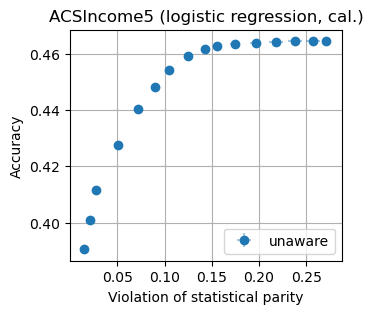

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464536  0.000294  0.270880  0.003440     0.143870  0.001004
0.260  0.464474  0.000269  0.257174  0.007222     0.139810  0.002045
0.240  0.464407  0.000265  0.237894  0.007402     0.134778  0.002008
0.220  0.464267  0.000299  0.217505  0.007382     0.130100  0.001786
0.200  0.463866  0.000272  0.196509  0.005965     0.126270  0.001418
0.180  0.463430  0.000319  0.174126  0.004443     0.123287  0.001188
0.160  0.462708  0.000358  0.155172  0.003980     0.119616  0.001080
0.140  0.461600  0.000356  0.142783  0.001432     0.116322  0.001427
0.120  0.459128  0.000280  0.124319  0.001535     0.100940  0.001325
0.100  0.454162  0.000173  0.104808  0.002332     0.084333  0.001449
0.080  0.448062  0.000185  0.089847  0.001342     0.068079  0.000963
0.060  0.440410  0.000317  0.071944  0.002598     0.053935  0.001303
0.040  0.427710  0.000446  0.051132  0.001275     0.037746  0.001794
0.020  0.411507  0.000625  0.026889  0.001231     0.021254  0.001050
0.010  0.401081  0.000486  0.020564  0.002892     0.014903  0.001845
0.001  0.390450  0.000284  0.014738  0.001613     0.009511  0.001325

In [22]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/85 [00:00<?, ?it/s]

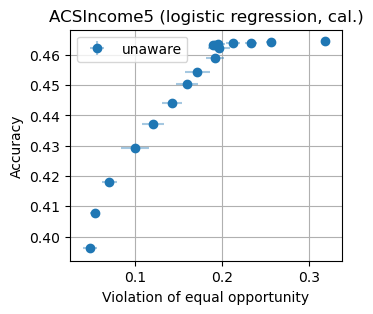

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464536  0.000294   0.318872  0.004689       0.157644  0.002350
0.300  0.464301  0.000263   0.256274  0.005021       0.125780  0.003086
0.280  0.464076  0.000267   0.233669  0.007047       0.120946  0.003119
0.260  0.463845  0.000271   0.213258  0.008253       0.117150  0.002960
0.240  0.463640  0.000314   0.196038  0.007210       0.114140  0.002406
0.220  0.463399  0.000309   0.190502  0.004372       0.113978  0.002016
0.200  0.463267  0.000260   0.192389  0.006553       0.114887  0.001770
0.180  0.462349  0.000242   0.196525  0.012773       0.115840  0.001713
0.150  0.459005  0.000404   0.191758  0.010359       0.102073  0.003110
0.120  0.454411  0.000342   0.172045  0.014734       0.094577  0.003249
0.100  0.450489  0.000398   0.159952  0.012739       0.085345  0.005048
0.080  0.444126  0.000572   0.143153  0.011316       0.078450  0.004958
0.060  0.437267  0.000621   0.120855  0.012642       0.067567  0.003951
0.040  0.429332  0.000699   0.100308  0.016438       0.055113  0.005610
0.020  0.417991  0.000610   0.070684  0.008758       0.041596  0.003418
0.010  0.407851  0.000910   0.054001  0.005801       0.032713  0.003149
0.001  0.396342  0.000862   0.048478  0.008355       0.029542  0.004897

In [23]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/85 [00:00<?, ?it/s]

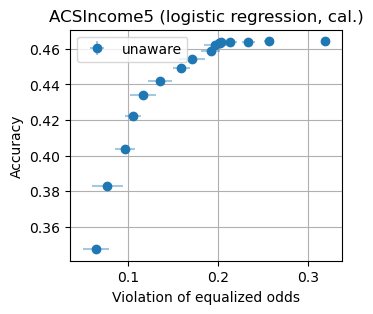

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464536  0.000294  0.318872  0.004689     0.106065  0.002286
0.300  0.464301  0.000263  0.256274  0.005021     0.091097  0.002007
0.280  0.464076  0.000267  0.233669  0.007047     0.088095  0.001718
0.260  0.463845  0.000271  0.213258  0.008253     0.085946  0.001580
0.240  0.463640  0.000314  0.203206  0.001007     0.084155  0.001325
0.220  0.463399  0.000309  0.201956  0.001958     0.083396  0.000788
0.200  0.463253  0.000260  0.200418  0.001855     0.083668  0.000977
0.180  0.462276  0.000254  0.196525  0.012773     0.084427  0.001362
0.150  0.458900  0.000403  0.191749  0.010365     0.079283  0.001670
0.120  0.454233  0.000370  0.171004  0.014156     0.072087  0.002254
0.100  0.449009  0.000539  0.159172  0.009923     0.061591  0.002020
0.080  0.442122  0.000580  0.135243  0.013048     0.053723  0.002185
0.060  0.433889  0.000741  0.116392  0.014491     0.045152  0.002565
0.040  0.422298  0.000433  0.105048  0.008764     0.034454  0.002210
0.020  0.403970  0.000712  0.096626  0.011241     0.028292  0.002940
0.010  0.382963  0.001107  0.076608  0.017300     0.024929  0.002923
0.001  0.347666  0.000718  0.063926  0.014780     0.021782  0.003220

In [24]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### Gradient boosting decision tree

In [25]:
# Train p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 734044, number of used features: 44
[LightGBM] [Info] Start training from score -1.964870
[LightGBM] [Info] Start training from score -1.970376
[LightGBM] [Info] Start training from score -1.767284
[LightGBM] [Info] Start training from score -1.805195
[LightGBM] [Info] Start training from score -1.803465
[LightGBM] [Info] Start training from score -3.832187
[LightGBM] [Info] Start training from score -3.827732
[LightGBM] [Info] Start training from score -3.863163
[LightGBM] [Info] Start training from score -4.224128
[LightGBM] [Info] Start training from score -4.637348
[LightGBM] [Info] Start training from score -6.064418
[LightGBM] [Info] Start training from score -6.070296

In [26]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/60 [00:00<?, ?it/s]

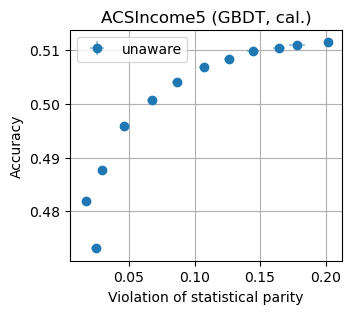

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511519  0.000377  0.201870  0.000784     0.117223  0.000734
0.180  0.510927  0.000495  0.177996  0.006079     0.110491  0.002030
0.160  0.510459  0.000485  0.164279  0.004545     0.105212  0.001548
0.140  0.509882  0.000536  0.144580  0.004344     0.100665  0.001283
0.120  0.508483  0.000494  0.126317  0.004097     0.094942  0.001884
0.100  0.506870  0.000526  0.106993  0.003204     0.082560  0.001077
0.080  0.504073  0.000542  0.086614  0.003870     0.068399  0.002292
0.060  0.500760  0.000522  0.067371  0.003655     0.053143  0.001734
0.040  0.495919  0.000457  0.046548  0.002395     0.037381  0.001815
0.020  0.487661  0.000378  0.029373  0.003029     0.022005  0.001741
0.010  0.481942  0.000289  0.017060  0.002350     0.011201  0.001373
0.001  0.473099  0.000402  0.024561  0.003530     0.015138  0.001079

In [27]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

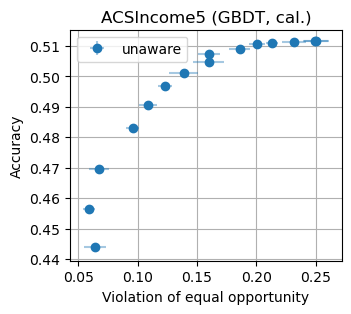

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.511519  0.000377   0.250658  0.010817       0.150776  0.003480
0.240  0.511508  0.000390   0.249906  0.010920       0.150527  0.003500
0.220  0.511271  0.000427   0.231438  0.010067       0.143015  0.004209
0.200  0.511016  0.000445   0.213271  0.004794       0.128733  0.005604
0.180  0.510679  0.000427   0.200574  0.006461       0.119376  0.005762
0.160  0.509040  0.000352   0.186273  0.008864       0.107541  0.003375
0.140  0.507357  0.000293   0.160226  0.009391       0.099977  0.001454
0.120  0.504677  0.000361   0.159874  0.012836       0.098031  0.003085
0.100  0.501098  0.000489   0.138972  0.012250       0.091738  0.003133
0.080  0.496929  0.000463   0.123014  0.005575       0.076891  0.003789
0.060  0.490667  0.000783   0.108790  0.007259       0.069114  0.002644
0.040  0.483068  0.000774   0.095848  0.005525       0.060395  0.001890
0.020  0.469535  0.000989   0.067609  0.008287       0.048779  0.001856
0.010  0.456590  0.001164   0.058955  0.005331       0.038309  0.002089
0.001  0.443868  0.000976   0.064041  0.009539       0.040090  0.003838

In [28]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

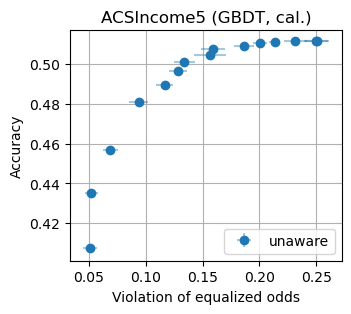

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511519  0.000377  0.250658  0.010817     0.099344  0.001467
0.240  0.511508  0.000390  0.249906  0.010920     0.099206  0.001476
0.220  0.511271  0.000427  0.231461  0.010053     0.094831  0.002253
0.200  0.511019  0.000452  0.213475  0.004640     0.085808  0.003409
0.180  0.510679  0.000427  0.200574  0.006461     0.079341  0.002679
0.160  0.509042  0.000354  0.186341  0.008851     0.072560  0.000807
0.140  0.507368  0.000332  0.159331  0.010548     0.071156  0.000423
0.120  0.504347  0.000474  0.156655  0.014412     0.064278  0.001225
0.100  0.500976  0.000525  0.133752  0.009163     0.055283  0.002035
0.080  0.496315  0.000603  0.128395  0.007508     0.050106  0.002514
0.060  0.489552  0.000726  0.116825  0.007484     0.043956  0.000755
0.040  0.480843  0.000799  0.093675  0.008709     0.035769  0.001520
0.020  0.456708  0.000748  0.068899  0.006783     0.027507  0.001292
0.010  0.435187  0.000961  0.052094  0.005579     0.021001  0.001174
0.001  0.407343  0.000891  0.050533  0.006128     0.021401  0.001636

In [29]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### ReLU network

In [30]:
# Train p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [31]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/75 [00:00<?, ?it/s]

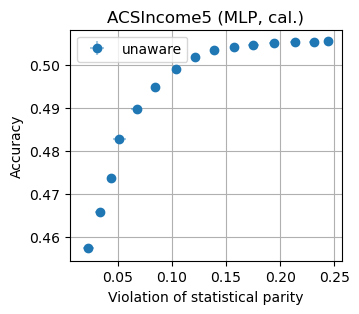

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.505459  0.000250  0.244353  0.000999     0.136794  0.000519
0.240  0.505370  0.000257  0.231037  0.004102     0.132039  0.001592
0.220  0.505230  0.000229  0.213401  0.004709     0.126249  0.001663
0.200  0.505090  0.000231  0.194585  0.004681     0.120900  0.001555
0.180  0.504669  0.000254  0.175134  0.005322     0.116402  0.001487
0.160  0.504130  0.000270  0.157433  0.004110     0.109180  0.001976
0.140  0.503526  0.000387  0.139177  0.002644     0.102127  0.001560
0.120  0.501839  0.000396  0.121662  0.004193     0.096240  0.002610
0.100  0.498925  0.000447  0.103530  0.003632     0.085119  0.000665
0.080  0.494783  0.000387  0.084321  0.003384     0.070720  0.000797
0.060  0.489664  0.000251  0.067316  0.005095     0.053060  0.000996
0.040  0.482914  0.000391  0.051297  0.006060     0.036927  0.000927
0.020  0.473850  0.000346  0.043564  0.003350     0.025170  0.001871
0.010  0.465959  0.000420  0.033034  0.004452     0.017365  0.002294
0.001  0.457549  0.000530  0.022405  0.005157     0.012959  0.002077

In [32]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/85 [00:00<?, ?it/s]

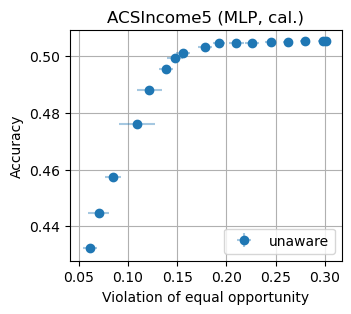

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.505459  0.000250   0.301065  0.003431       0.159863  0.002366
0.300  0.505435  0.000257   0.298289  0.005535       0.158322  0.003471
0.280  0.505312  0.000241   0.280244  0.005155       0.149177  0.003166
0.260  0.505206  0.000228   0.262352  0.005014       0.141783  0.003097
0.240  0.505083  0.000236   0.244863  0.005827       0.136548  0.002997
0.220  0.504881  0.000263   0.225817  0.006917       0.131718  0.003365
0.200  0.504662  0.000260   0.209843  0.007627       0.124820  0.004450
0.180  0.504654  0.000342   0.192927  0.006008       0.113502  0.004246
0.150  0.503467  0.000281   0.178392  0.007245       0.099843  0.003412
0.120  0.501179  0.000225   0.156078  0.007111       0.086395  0.001695
0.100  0.499442  0.000230   0.147963  0.008431       0.085748  0.001494
0.080  0.495693  0.000311   0.138881  0.006891       0.081766  0.001081
0.060  0.488296  0.000412   0.121712  0.012720       0.074362  0.002778
0.040  0.475949  0.000645   0.109193  0.017915       0.068014  0.006372
0.020  0.457479  0.000669   0.084612  0.008017       0.053762  0.005021
0.010  0.444646  0.000623   0.070204  0.010367       0.045416  0.003861
0.001  0.432279  0.000752   0.061362  0.007460       0.038262  0.001949

In [33]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/85 [00:00<?, ?it/s]

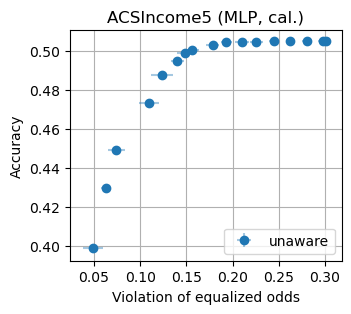

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.505459  0.000250  0.301065  0.003431     0.104826  0.001208
0.300  0.505435  0.000257  0.298289  0.005535     0.103908  0.001580
0.280  0.505312  0.000241  0.280244  0.005155     0.098252  0.001505
0.260  0.505206  0.000228  0.262352  0.005014     0.093371  0.001509
0.240  0.505083  0.000236  0.244863  0.005827     0.089633  0.001473
0.220  0.504881  0.000263  0.225817  0.006917     0.086807  0.001624
0.200  0.504662  0.000260  0.209843  0.007627     0.082761  0.002941
0.180  0.504654  0.000342  0.192927  0.006008     0.075520  0.002441
0.150  0.503465  0.000283  0.178392  0.007245     0.066489  0.001361
0.120  0.500921  0.000183  0.156078  0.007111     0.057005  0.001003
0.100  0.498955  0.000200  0.147956  0.008431     0.052223  0.000964
0.080  0.495225  0.000349  0.140332  0.007506     0.050036  0.002068
0.060  0.487797  0.000429  0.123519  0.011944     0.040495  0.002209
0.040  0.473769  0.000554  0.109047  0.010753     0.036120  0.002195
0.020  0.449523  0.000808  0.074204  0.008851     0.026130  0.002697
0.010  0.430036  0.000749  0.062894  0.005359     0.022153  0.001622
0.001  0.398909  0.000890  0.048533  0.010884     0.018074  0.002031

In [34]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)